# Gambler's Problem, a TD(0) solver

The problem setup is taken from Example 4.2 in Sutton & Barto's *Reinforcement Learning*. Though the related exercise states we should use value iteration, here we just use a temporal-difference algorithm.

## Algorithm

Starting off, we initialize each state-value (of the 101 possible, from \\$0 to \\$100 inclusive) in a table with value 0.9; we use this value instead of 0.5 because an optimistic initial value function tends to converge faster (see Sutton & Barto). The first and last values are initialized to 0.0 and 1.0, respectively, for win/lose states.

The agent considers the two possible afterstates of each possible action (stake) given its current balance, one for losing and winning each. The problem statement necessitates that the gambler agent wins a bonus on heads and loses his stake on tails. When a decision is chosen, a temporal-difference step is performed.

We use an epsilon-greedy policy evaluation to select between the believed optimal action and a random action.

## Cached Results

I began with a high initial value for $\epsilon$ and $\alpha$, gradually annealing each of them (primarily $\alpha$) by hand once convergence was achieved.

In [214]:
# Probability of the coin landing on heads. [0.0, 1.0]
pₕ = 0.5

# Probability of choosing a random action instead of that which is believed to be optimal. [0.0, 1.0]
ϵ = 1e-2

# Learning rate. [0.0, 1.0]
α = 3e-4

0.0003

In [111]:
import Pkg

Pkg.add("LaTeXStrings")
Pkg.add("Plots")
Pkg.add("StaticArrays")

  Resolving package versions...
   Updating `~/Project.toml`
 [no changes]
   Updating `~/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Project.toml`
 [no changes]
   Updating `~/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/Project.toml`
 [no changes]
   Updating `~/Manifest.toml`
 [no changes]


In [176]:
using StaticArrays

state_values = ones(MArray{Tuple{101}, Float64}) * 0.9
state_values[1] = 0.0
state_values[101] = 1.0

state_values

101-element MArray{Tuple{101},Float64,1,101} with indices SOneTo(101):
 0.0
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 ⋮
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 0.9
 1.0

In [177]:
function optimal_stake(current_state :: Integer) :: Integer
    balance = current_state - 1
    
    best_choice = 0
    best_value = 0
    for choice in 1:min(balance, 100 - balance)
        value = state_values[current_state + choice] * pₕ + state_values[current_state - choice] * (1.0 - pₕ)
        if value > best_value
            best_choice = choice
            best_value = value
        end
    end
    
    return best_choice
end

optimal_stake (generic function with 2 methods)

In [178]:
function coin_flip() :: Bool
    # true: Heads; false: Tails
    return rand() < pₕ
end

coin_flip (generic function with 1 method)

In [179]:
function td_episode() :: Nothing
    current_state = rand(2:100)
    
    while current_state != 1 && current_state != 101
        # Stake selection.
        if rand() > ϵ # Exploit.
            stake = optimal_stake(current_state)
        else # Explore. Select a random stake.
            stake = rand(1:min(current_state - 1, 101 - current_state))
        end

        if coin_flip() # Heads (win).
            after_state = current_state + stake
        else # Tails (lose).
            after_state = current_state - stake
        end

        # TD-update.
        state_values[current_state] += α * (state_values[after_state] - state_values[current_state])
        
        # Update current state.
        current_state = after_state
    end
    
    return
end

td_episode (generic function with 1 method)

In [229]:
iterations = 1e5

@time begin
    for _ in 1:iterations
        td_episode()
    end
end
    
state_values

  7.155295 seconds (184.78 M allocations: 2.755 GiB, 14.86% gc time)


101-element MArray{Tuple{101},Float64,1,101} with indices SOneTo(101):
 0.0
 0.010268595736559966
 0.02013256462618594
 0.030261352879263164
 0.04070622173203998
 0.050802419298790605
 0.061019496650219426
 0.07078171910444951
 0.08100645423008433
 0.09145785044607004
 0.1005165921611258
 0.11068525165439481
 0.12179886618911769
 ⋮
 0.8915165234268888
 0.9021987657601775
 0.9117709137867854
 0.9216904327512848
 0.9307058804025612
 0.9412478704111729
 0.9509079286412623
 0.9615447915489436
 0.970266492705464
 0.9801679139959442
 0.9900047644463554
 1.0

In [230]:
import Plots: plot, scatter
using LaTeXStrings

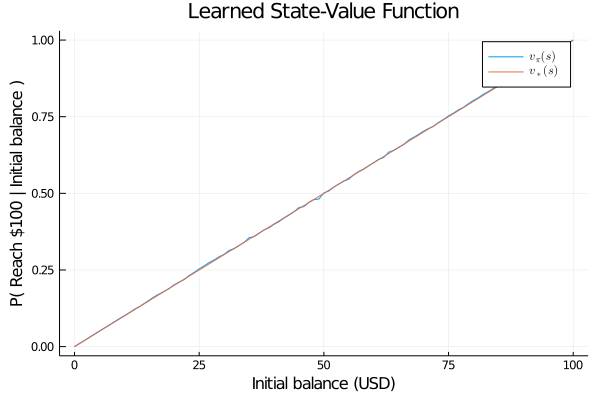

In [231]:
plot(0:100,
     [state_values, (0:100) / 100],
     title = "Learned State-Value Function",
     label = [L"v_\pi(s)" L"v_*(s)"],
     xlabel = "Initial balance (USD)",
     ylabel = "P( Reach \$100 | Initial balance )")

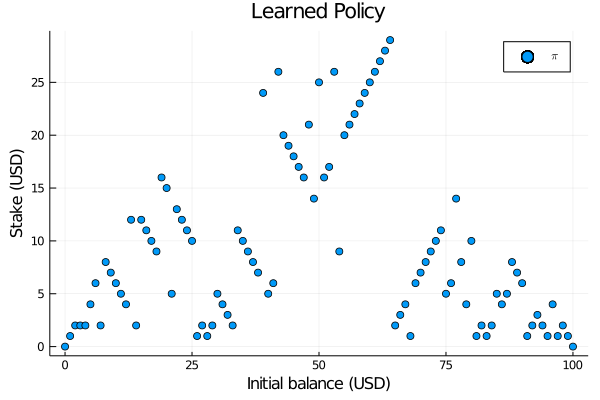

In [232]:
scatter(0:100,
        optimal_stake.(1:101),
        title = "Learned Policy",
        label = L"\pi",
        xlabel = "Initial balance (USD)",
        ylabel = "Stake (USD)")